In [1]:
#%reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
#oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=10) #need for neural network and random forest
import pickle


Read in data

In [25]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1697/3165355871.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


Functions

In [35]:
def merge_and_rename_data(data1, data2, on_column, suffix1, suffix2):
    merged_data = pd.merge(data1, data2, on=on_column, suffixes=('_'+suffix1, '_'+suffix2))

    new_column_names = [col.replace(f'_{on_column}_{suffix1}', f'_{suffix1}').replace(f'_{on_column}_{suffix2}', f'_{suffix2}') for col in merged_data.columns]
    merged_data.rename(columns=dict(zip(merged_data.columns, new_column_names)), inplace=True)

    return merged_data

def pivot_data_by_HSA(data, index_column, columns_column, values_column):
    data_by_HSA = data[[index_column, columns_column, values_column]]
    pivot_table = data_by_HSA.pivot_table(index=index_column, columns=columns_column, values=values_column)
    return pivot_table

def create_column_names(categories_for_subsetting, num_of_weeks):
    column_names = ['HSA_ID']

    for week in range(1, num_of_weeks + 1):
        week = num2words(week)
        for category in categories_for_subsetting:
            column_name = f'week_{week}_{category}'
            column_names.append(column_name)

    return column_names
    
def create_collated_weekly_data(pivoted_table, original_data, categories_for_subsetting, geography, column_names):
    collated_data = pd.DataFrame(index=range(51), columns=column_names)

    x = 0
    for geo in original_data[geography].unique():
        #matching_indices = [i for i, geo_col in enumerate(pivoted_table) if geo_col == geo]
        collated_data.loc[x, geography] = geo
        columns_to_subset = [f'{geo}_{category}' for category in categories_for_subsetting]
        j = 1
        try:
            for row in range(len(pivoted_table.loc[:, columns_to_subset])):
                collated_data.iloc[x, j:j + len(categories_for_subsetting)] = pivoted_table.loc[row, columns_to_subset]
                j += len(categories_for_subsetting)
        except:
            pass
        x += 1

    return collated_data


def add_changes_by_week(weekly_data_frame, outcome_column):

    for column in weekly_data_frame.columns[1:]:
        # Calculate the difference between each row and the previous row
        if outcome_column not in column.lower(): #want to leave out the outcome column
            diff = weekly_data_frame[column].diff()
            
            # Create a new column with the original column name and "delta"
            new_column_name = column + "_delta"
            
            column_index = weekly_data_frame.columns.get_loc(column)
            
            # Insert the new column just after the original column
            weekly_data_frame.insert(column_index + 1, new_column_name, diff)
            weekly_data_frame[new_column_name] = diff
    return weekly_data_frame


def prep_training_test_data_period(data, no_weeks, weeks_in_futre, if_train, geography, weight_col):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        for week_y in range(week+1, test_week+1):
                y_weeks_to_check.append('_' + num2words(week_y) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
            train_week = w2n.word_to_num(x_week.replace("_", ""))
            target_week =  w2n.word_to_num(y_week.replace("_", ""))
            y_weeks_to_check = []
            for week_to_check in range(train_week + 1, target_week + 1):
                y_weeks_to_check.append('_' + num2words(week_to_check) + '_')

            y_weeks_to_check = [week + 'beds_over_15_100k' for week in y_weeks_to_check]
            columns_to_check = [col for col in data.columns if any(week in col for week in y_weeks_to_check)]
            y_over_in_period = data[columns_to_check].apply(max, axis=1)
            data_y = pd.concat([data_y, y_over_in_period], axis=1)
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week, inlcuding it as a feature

            #rename columns for concatenation 
            X_week.columns = range(1, len(data_x.columns) -1)
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)

def calculate_ppv_npv(true_labels, predicted_labels):
    # Make sure the inputs have the same length
    if len(true_labels) != len(predicted_labels):
        raise ValueError("The true_labels and predicted_labels should have the same length.")

    true_positives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 1 and predicted_label == 1)
    false_positives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 0 and predicted_label == 1)
    true_negatives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 0 and predicted_label == 0)
    false_negatives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 1 and predicted_label == 0)

    ppv = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    npv = true_negatives / (true_negatives + false_negatives) if (true_negatives + false_negatives) > 0 else 0.0

    return ppv, npv

Rename weeks so 7/10/2022 is the first

In [27]:
for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

Create dataframe

In [28]:
## pivot 
data_by_HSA_cases = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_deaths = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'deaths_weekly')
data_by_HSA_admissions = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_icu = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_15_100k = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge 
data_by_HSA_cases_deaths = merge_and_rename_data(data_by_HSA_cases, data_by_HSA_deaths,'week','cases', 'deaths')
data_by_HSA_admits_icu_weekly = merge_and_rename_data(data_by_HSA_admissions, data_by_HSA_icu,'week','admits', 'icu')
data_by_HSA_beds_perc_weekly = merge_and_rename_data(data_by_HSA_beds, data_by_HSA_percent_beds,'week','beds', 'perc_covid')
data_by_HSA_cases_deaths_admits_icu = pd.merge(data_by_HSA_cases_deaths, data_by_HSA_admits_icu_weekly, on='week')
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu, data_by_HSA_beds_perc_weekly, on='week')

## add outcome variable 

old_column_names = data_by_HSA_over_15_100k.columns
new_column_names = [str(col) + '_beds_over_15_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_15_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA_over_15_100k, on='week')

data_by_HSA_cases_deaths_admits_icu_beds = data_by_HSA_cases_deaths_admits_icu_beds.reset_index()
data_by_HSA_cases_deaths_admits_icu_beds.columns = data_by_HSA_cases_deaths_admits_icu_beds.columns.str.replace(',', '')

In [29]:
categories_for_subsetting = ['cases', 'deaths', 'admits', 'icu', 'beds', 'perc_covid', 'beds_over_15_100k']
num_of_weeks = len(data_by_HSA_cases_deaths_admits_icu_beds)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

In [30]:

all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA, categories_for_subsetting, 'HSA_ID', column_names)

In [32]:
all_HSA_ID_weekly_data = add_changes_by_week(all_HSA_ID_weekly_data, "beds_over_15_100k")

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1697/3772980716.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1697/3772980716.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1697/3772980716.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usu

Add weights

In [33]:
weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

Get test/train dataset 
    - including "outcome" as a predictor 
    - not oversampling, using balanced weights
    - look at 3 week period rather than exactly three weeks

In [36]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
weights = weights[0].to_numpy()

Create decision tree

In [37]:
param_grid = {
    'criterion': ['gini'],#,  'entropy'],
    #'max_depth': np.arange(2, 20),
    'min_samples_split':  np.arange(2, 300), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 400)} #100, 200, 300, 400, 500], #np.arange(500, 200)}


# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
plt.savefig('Graphs/Full_classifier_3_week_period_unpruned.png', dpi = 300)

In [286]:
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

Accuracy: 0.7995618133195863
auROC: 0.8199346100567563


In [ ]:
plt.savefig('Graphs/Full_classifier_3_week_period_unpruned.png', dpi = 300)

In [288]:
model_name = "Full_model_auroc_unpruned_0.819934.sav" 
#pickle.dump(clf, open(model_name, 'wb'))
#clf = pickle.load(open(model_name, 'rb'))


In [279]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.7994576605448046
specificity:  0.8499552105106002
ppv:  0.9508869667204223
npv:  0.5383960658218271


Now look at each week in the three week period - which one has the best preedictive capacity? 

In [31]:
### this code it's exactly in  x weeks 
def prep_training_test_data(data, no_weeks, weeks_in_futre, if_train, geography, weight_col):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')

    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]

            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:
                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week, inlcuding it as a feature

            #rename columns for concatenation 
            X_week.columns = range(1, len(data_x.columns) -1)
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)



In [141]:
weeks_to_predict = range(0,4)
ROC_by_week = []
#
for prediction_week in weeks_to_predict: 
    
    X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
    weights = weights[0]
    clf.fit(X_train, y_train[0],  sample_weight = weights)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test[0], y_pred)
    ROC_by_week.append(roc_auc_score(y_test[0], y_pred))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.28837500141765104


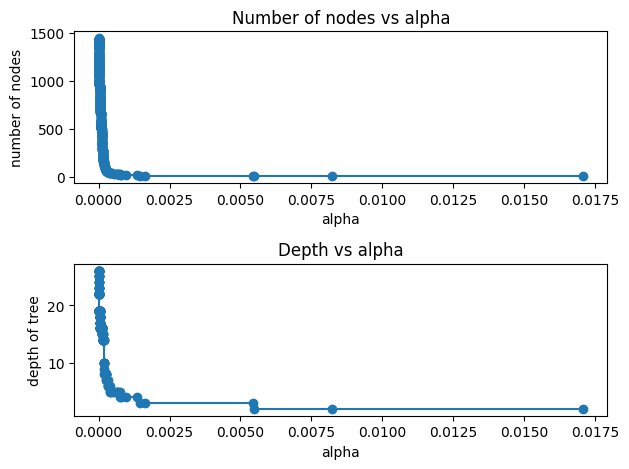

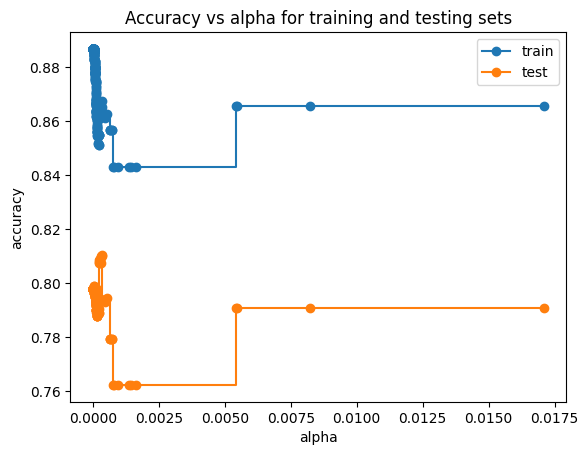

In [219]:
#clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train, y_train,  sample_weight = weights )
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

auROC: 0.8247064355277024
[[ 5693  1005]
 [ 4881 19458]]


[Text(0.38513513513513514, 0.9285714285714286, 'beds <= 20.716\ngini = 0.5\nsamples = 65473\nvalue = [40.768, 40.768]'),
 Text(0.12162162162162163, 0.7857142857142857, 'beds <= 10.315\ngini = 0.231\nsamples = 13883\nvalue = [36.557, 5.615]'),
 Text(0.05405405405405406, 0.6428571428571429, 'admits <= 1.558\ngini = 0.164\nsamples = 9361\nvalue = [31.126, 3.083]'),
 Text(0.02702702702702703, 0.5, 'gini = 0.117\nsamples = 5788\nvalue = [22.852, 1.515]'),
 Text(0.08108108108108109, 0.5, 'cases <= 115.5\ngini = 0.268\nsamples = 3573\nvalue = [8.274, 1.568]'),
 Text(0.05405405405405406, 0.35714285714285715, 'gini = 0.229\nsamples = 2621\nvalue = [6.945, 1.055]'),
 Text(0.10810810810810811, 0.35714285714285715, 'gini = 0.402\nsamples = 952\nvalue = [1.329, 0.513]'),
 Text(0.1891891891891892, 0.6428571428571429, 'cases <= 24.5\ngini = 0.434\nsamples = 4522\nvalue = [5.431, 2.532]'),
 Text(0.16216216216216217, 0.5, 'gini = 0.304\nsamples = 956\nvalue = [1.953, 0.448]'),
 Text(0.21621621621621623

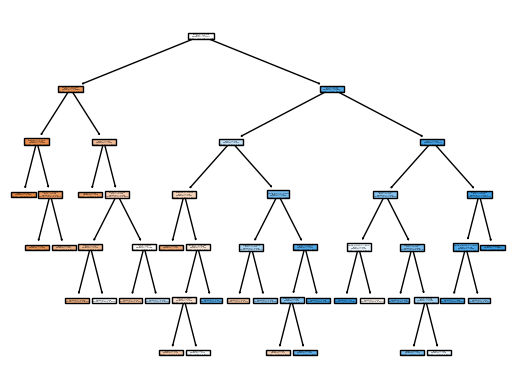

In [265]:
clf_pruned = clfs[test_scores.index(max(test_scores))]
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
weights = weights[0]
clf_pruned.fit(X_train, y_train,  sample_weight = weights)

    # Make predictions on the test set
y_pred = clf_pruned.predict(X_test)
    # Evaluate the accuracy of the model
roc = roc_auc_score(y_test, y_pred)

print("auROC:", roc)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf_pruned, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#plt.savefig('Graphs/Full_classifier_3_week_period_pruned.png', dpi = 300)

In [236]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.7994576605448046
specificity:  0.8499552105106002
ppv:  0.9508869667204223
npv:  0.5383960658218271


In [ ]:
print(tree.export_text(clf_pruned))

In [231]:
model_name = "Full_model_pruned_auroc_0.81035538.sav" 
pickle.dump(clf, open(model_name, 'wb'))
#clf = pickle.load(open(model_name, 'rb'))

# best parameters
best_params = ccp_alpha=0.00034432296009090715,
                       class_weight='balanced', min_samples_leaf=14,
                       min_samples_split=52, random_state=10

Which week drove predictions

In [277]:
weeks_to_predict = range(1,4)
ROC_by_week = []
sensitivity_by_week = []
specificity_by_week = []
ppv_by_week = []
npv_by_week = []

#
for prediction_week in weeks_to_predict: 
    print(prediction_week)
    X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
    weights = weights[0]
    clf_pruned.fit(X_train, y_train,  sample_weight = weights)

    # Make predictions on the test set
    y_pred = clf_pruned.predict(X_test)
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    ROC_by_week.append(roc_auc_score(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)

    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    # Calculate specificity (true negative rate)
    specificity_by_week.append(TN / (TN + FP))
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week.append(TP / (TP + FN))

    ppv, npv = calculate_ppv_npv(y_test, y_pred)
    ppv_by_week.append(ppv)
    npv_by_week.append(npv)

1
2
3


# Try oversampling to see if it improves predictions 

In [ ]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = True, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
weights = weights[0].to_numpy()

Accuracy: 0.7995618133195863
auROC: 0.8199346100567563
[[ 5732   966]
 [ 5255 19084]]


[Text(0.44127155172413796, 0.9444444444444444, 'beds <= 20.716\ngini = 0.5\nsamples = 65473\nvalue = [40.768, 40.768]'),
 Text(0.2478448275862069, 0.8333333333333334, 'beds <= 10.315\ngini = 0.231\nsamples = 13883\nvalue = [36.557, 5.615]'),
 Text(0.15660919540229884, 0.7222222222222222, 'admits <= 1.558\ngini = 0.164\nsamples = 9361\nvalue = [31.126, 3.083]'),
 Text(0.07183908045977011, 0.6111111111111112, 'cases <= 24.5\ngini = 0.117\nsamples = 5788\nvalue = [22.852, 1.515]'),
 Text(0.022988505747126436, 0.5, 'deaths <= 0.198\ngini = 0.069\nsamples = 1970\nvalue = [9.349, 0.345]'),
 Text(0.011494252873563218, 0.3888888888888889, 'gini = 0.041\nsamples = 693\nvalue = [3.682, 0.079]'),
 Text(0.034482758620689655, 0.3888888888888889, 'beds <= 1.354\ngini = 0.086\nsamples = 1277\nvalue = [5.667, 0.266]'),
 Text(0.022988505747126436, 0.2777777777777778, 'delta_admits <= -2.285\ngini = 0.074\nsamples = 902\nvalue = [4.185, 0.168]'),
 Text(0.011494252873563218, 0.16666666666666666, 'gini = 

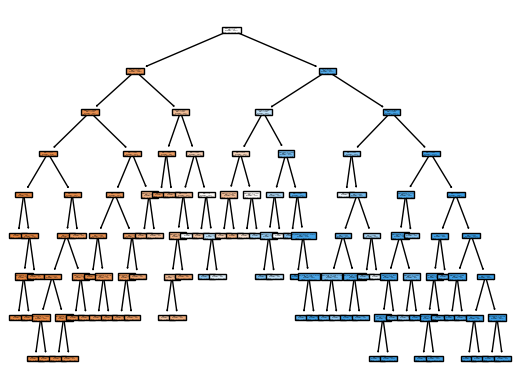

In [269]:
param_grid = {
    'criterion': ['gini'],#,  'entropy'],
    'max_depth': np.arange(2, 20),
    'min_samples_split':  np.arange(2, 300), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(100, 400)} #100, 200, 300, 400, 500], #np.arange(500, 200)}


# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=10, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#plt.savefig('Graphs/Full_classifier_3_week_period_unpruned_oversample.png', dpi = 300)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.28837500141765077


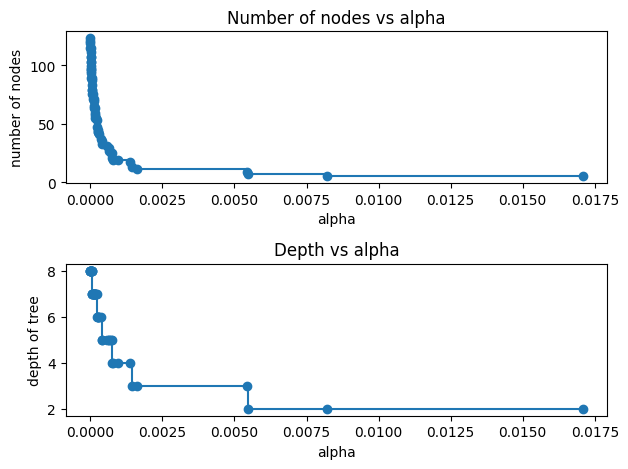

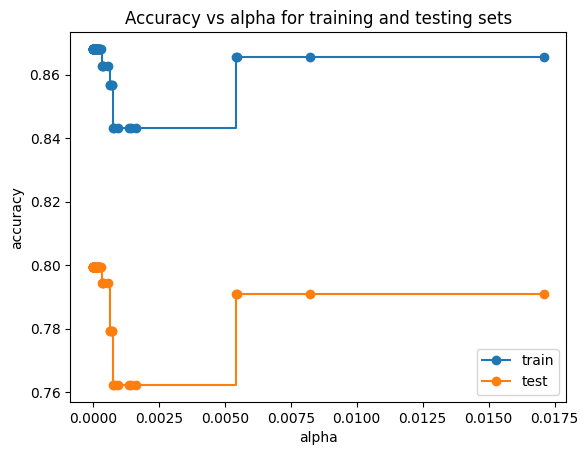

In [271]:
#clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train, y_train,  sample_weight = weights )
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# Could skip the next week 

In [11]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')


Shift data down one 
No oversampling 

In [12]:
y_train_shifted = y_train.shift(1)
y_test_shifted = y_test.shift(1)

y_train_shifted.drop(index = 0, inplace = True)
y_test_shifted.drop(index = 0, inplace = True)
X_train.drop(index = 0, inplace = True)
X_test.drop(index = 0, inplace = True)
weights.drop(index = 0, inplace = True)
weights = weights[0].to_numpy()

Accuracy: 0.7612450057997164
auROC: 0.7981497633321696
[[ 5780   917]
 [ 6493 17846]]


[Text(0.37775222558124, 0.9705882352941176, 'delta_bedsperc_covid <= -12.857\ngini = 0.5\nsamples = 65472\nvalue = [40.767, 40.767]'),
 Text(0.13340125601282737, 0.9117647058823529, 'beds <= 4.867\ngini = 0.218\nsamples = 26313\nvalue = [2.55, 17.886]'),
 Text(0.08307723142704436, 0.8529411764705882, 'delta_icu <= -0.052\ngini = 0.481\nsamples = 4276\nvalue = [1.851, 2.751]'),
 Text(0.05418225547835382, 0.7941176470588235, 'delta_bedsperc_covid <= -26.189\ngini = 0.369\nsamples = 3078\nvalue = [0.661, 2.053]'),
 Text(0.04102084446819882, 0.7352941176470589, 'beds_over_15_100k <= -0.027\ngini = 0.184\nsamples = 2447\nvalue = [0.191, 1.668]'),
 Text(0.030732228754676644, 0.6764705882352942, 'delta_admits <= 4.012\ngini = 0.128\nsamples = 2018\nvalue = [0.102, 1.382]'),
 Text(0.022982362373062535, 0.6176470588235294, 'delta_cases <= 1.5\ngini = 0.099\nsamples = 1841\nvalue = [0.07, 1.263]'),
 Text(0.01389631213254944, 0.5588235294117647, 'delta_icu <= -1.084\ngini = 0.05\nsamples = 1397\n

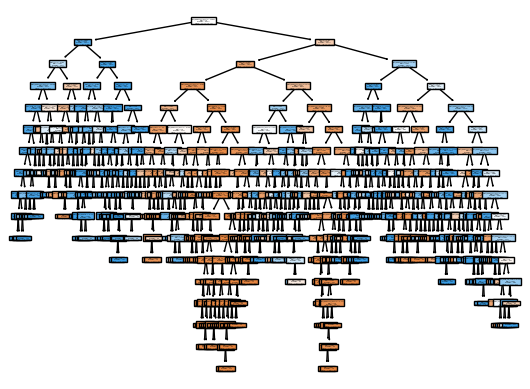

In [14]:
param_grid = {
    'criterion': ['gini'],#,  'entropy'],
    #'max_depth': np.arange(2, 20),
    'min_samples_split':  np.arange(2, 300), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 400)} #100, 200, 300, 400, 500], #np.arange(500, 200)}


# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf_shifted = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf_shifted, param_grid, n_iter=10, cv=cv, random_state=10)
random_search.fit(X_train, y_train_shifted, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf_shifted = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf_shifted.fit(X_train, y_train_shifted,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf_shifted.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_shifted, y_pred)
ROC = roc_auc_score(y_test_shifted, y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test_shifted, y_pred))
plot_tree(clf_shifted, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#lt.savefig('Graphs/Full_classifier_3_week_period_unpruned.png', dpi = 300)

[Text(0.3681098090277778, 0.9615384615384616, 'delta_bedsperc_covid <= -12.857\ngini = 0.5\nsamples = 65472\nvalue = [40.767, 40.767]'),
 Text(0.1293402777777778, 0.8846153846153846, 'beds <= 4.867\ngini = 0.218\nsamples = 26313\nvalue = [2.55, 17.886]'),
 Text(0.07291666666666667, 0.8076923076923077, 'delta_icu <= -0.052\ngini = 0.481\nsamples = 4276\nvalue = [1.851, 2.751]'),
 Text(0.04861111111111111, 0.7307692307692307, 'delta_bedsperc_covid <= -26.189\ngini = 0.369\nsamples = 3078\nvalue = [0.661, 2.053]'),
 Text(0.034722222222222224, 0.6538461538461539, 'beds_over_15_100k <= -0.027\ngini = 0.184\nsamples = 2447\nvalue = [0.191, 1.668]'),
 Text(0.027777777777777776, 0.5769230769230769, 'delta_cases <= 1.5\ngini = 0.128\nsamples = 2018\nvalue = [0.102, 1.382]'),
 Text(0.020833333333333332, 0.5, 'cases <= 50.5\ngini = 0.079\nsamples = 1502\nvalue = [0.045, 1.032]'),
 Text(0.013888888888888888, 0.4230769230769231, 'beds_over_15_100k <= -0.055\ngini = 0.161\nsamples = 672\nvalue = [0.

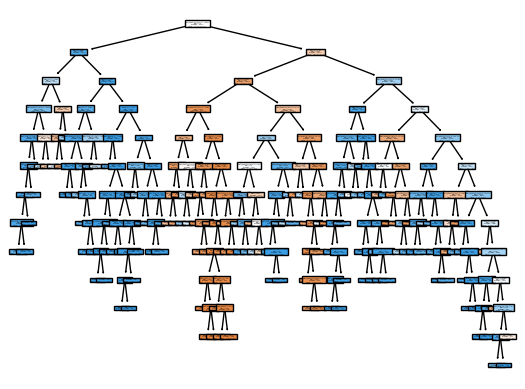

In [299]:
plot_tree(clf_shifted, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)


Number of nodes in the last tree is: 3 with ccp_alpha: 0.09417335376820718


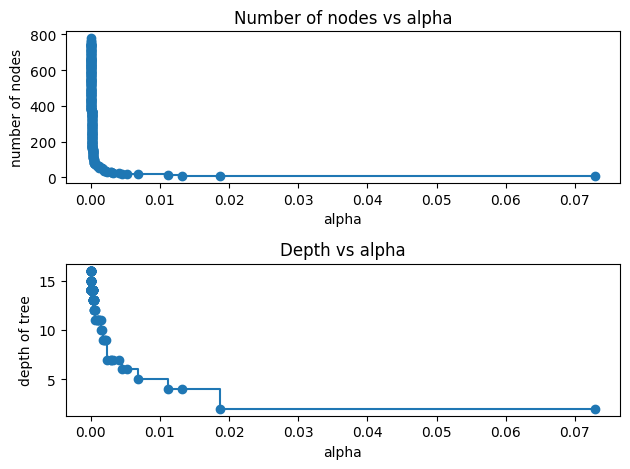

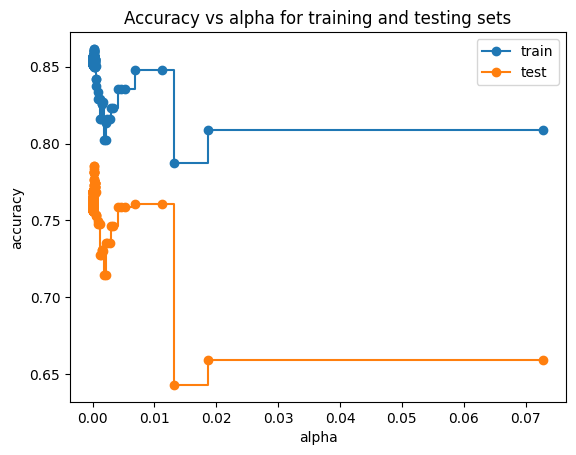

In [15]:
#clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

path = clf_shifted.cost_complexity_pruning_path(X_train, y_train_shifted)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train, y_train_shifted,  sample_weight = weights)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train_shifted) for clf in clfs]
test_scores = [clf.score(X_test, y_test_shifted) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

auROC: 0.8080056064148848
[[ 5674  1023]
 [ 5628 18711]]


[Text(0.32830668604651164, 0.9666666666666667, 'delta_bedsperc_covid <= -12.857\ngini = 0.5\nsamples = 65472\nvalue = [40.767, 40.767]'),
 Text(0.12209302325581395, 0.9, 'beds <= 4.867\ngini = 0.218\nsamples = 26313\nvalue = [2.55, 17.886]'),
 Text(0.06976744186046512, 0.8333333333333334, 'delta_icu <= -0.052\ngini = 0.481\nsamples = 4276\nvalue = [1.851, 2.751]'),
 Text(0.031007751937984496, 0.7666666666666667, 'delta_bedsperc_covid <= -26.189\ngini = 0.369\nsamples = 3078\nvalue = [0.661, 2.053]'),
 Text(0.015503875968992248, 0.7, 'beds_over_15_100k <= -0.027\ngini = 0.184\nsamples = 2447\nvalue = [0.191, 1.668]'),
 Text(0.007751937984496124, 0.6333333333333333, 'gini = 0.128\nsamples = 2018\nvalue = [0.102, 1.382]'),
 Text(0.023255813953488372, 0.6333333333333333, 'gini = 0.362\nsamples = 429\nvalue = [0.089, 0.286]'),
 Text(0.046511627906976744, 0.7, 'delta_icu <= -1.347\ngini = 0.495\nsamples = 631\nvalue = [0.471, 0.384]'),
 Text(0.03875968992248062, 0.6333333333333333, 'gini = 0

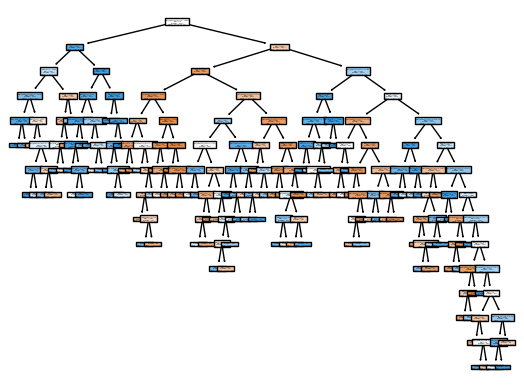

In [17]:
clf_shifted_pruned = clfs[test_scores.index(max(test_scores))]
clf_shifted_pruned.fit(X_train, y_train_shifted,  sample_weight = weights)

    # Make predictions on the test set
y_pred = clf_shifted_pruned.predict(X_test)
    # Evaluate the accuracy of the model
roc = roc_auc_score(y_test_shifted, y_pred)

print("auROC:", roc)

print(confusion_matrix(y_test_shifted, y_pred))
plot_tree(clf_shifted_pruned, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#plt.savefig('Graphs/Full_classifier_3_week_period_pruned_shifted.png', dpi = 300)

In [19]:
conf_matrix = confusion_matrix(y_test_shifted, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.7687661777394306
specificity:  0.847245035090339
ppv:  0.9481605351170569
npv:  0.5020350380463635


# Exactly 3 week prediction

In [23]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
weights = weights[0].to_numpy()

Accuracy: 0.6221622836592493
auROC: 0.7450774621896181
[[ 3985   367]
 [11400 15391]]


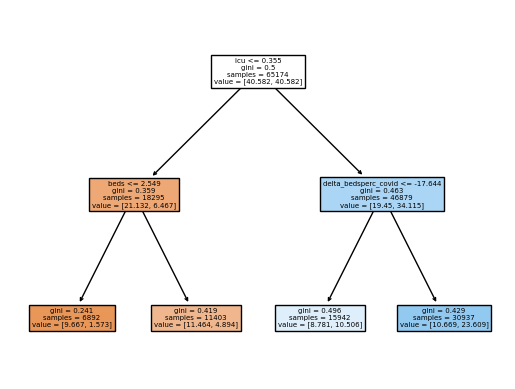

In [24]:
param_grid = {
    'criterion': ['gini'],#,  'entropy'],
    'max_depth': np.arange(2, 20),
    'min_samples_split':  np.arange(2, 300), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 400)} #100, 200, 300, 400, 500], #np.arange(500, 200)}


# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=200, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
plt.savefig('Graphs/Full_classifier_3_week_exact_unpruned.png', dpi = 300)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

Number of nodes in the last tree is: 3 with ccp_alpha: 0.07273714251026714


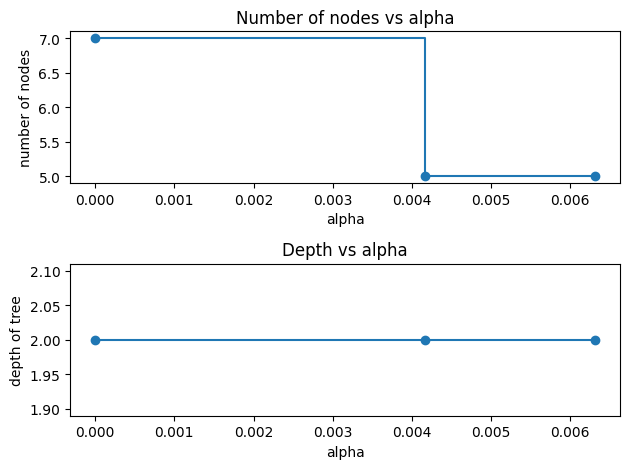

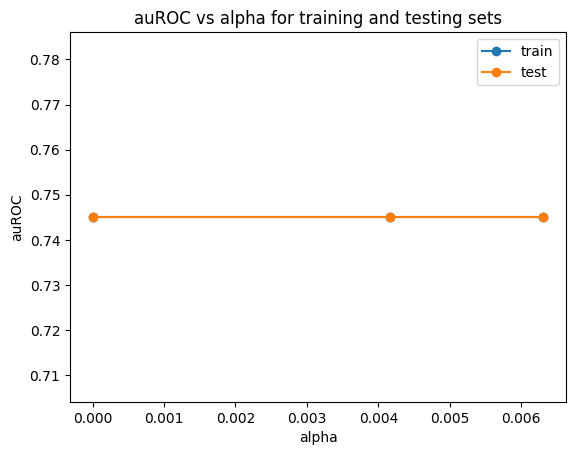

In [311]:

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train, y_train,  sample_weight = weights)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
train_scores = [roc_auc_score(y_test[0], y_pred) for clf in clfs]
test_scores = [roc_auc_score(y_test[0], y_pred) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("auROC")
ax.set_title("auROC vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

auROC: 0.6964463577471692
[[ 3993   359]
 [14055 12736]]


[Text(0.34555024756878555, 0.9761904761904762, 'icu <= 0.355\ngini = 0.5\nsamples = 65174\nvalue = [40.582, 40.582]'),
 Text(0.11869959677419355, 0.9285714285714286, 'beds <= 2.549\ngini = 0.359\nsamples = 18295\nvalue = [21.132, 6.467]'),
 Text(0.04981024667931689, 0.8809523809523809, 'deaths <= 0.465\ngini = 0.241\nsamples = 6892\nvalue = [9.667, 1.573]'),
 Text(0.018026565464895637, 0.8333333333333334, 'icu <= 0.062\ngini = 0.13\nsamples = 2162\nvalue = [3.491, 0.262]'),
 Text(0.016129032258064516, 0.7857142857142857, 'delta_bedsperc_covid <= -20.014\ngini = 0.121\nsamples = 2074\nvalue = [3.382, 0.234]'),
 Text(0.007590132827324478, 0.7380952380952381, 'delta_cases <= -270.5\ngini = 0.078\nsamples = 913\nvalue = [1.561, 0.067]'),
 Text(0.0056925996204933585, 0.6904761904761905, 'gini = 0.211\nsamples = 66\nvalue = [0.096, 0.013]'),
 Text(0.009487666034155597, 0.6904761904761905, 'deaths <= 0.366\ngini = 0.068\nsamples = 847\nvalue = [1.465, 0.053]'),
 Text(0.007590132827324478, 0.6

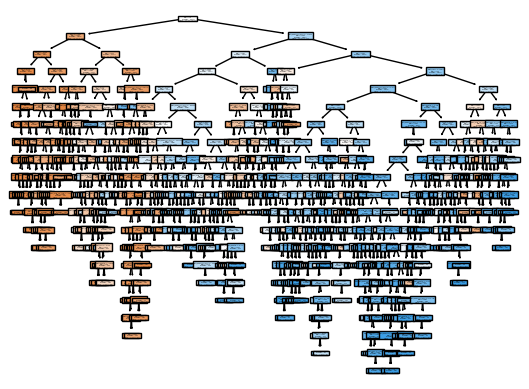

In [309]:
clf_pruned = clfs[test_scores.index(max(test_scores))]
clf_pruned.fit(X_train, y_train,  sample_weight = weights)

    # Make predictions on the test set
y_pred = clf_pruned.predict(X_test)
    # Evaluate the accuracy of the model
roc = roc_auc_score(y_test, y_pred)

print("auROC:", roc)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf_pruned, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#plt.savefig('Graphs/Full_classifier_3_week_exact_pruned.png', dpi = 300)